In [290]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

### Nota

Note que odeint aplica LSOAD para cada uno de los elementos del array state.

Sobre el array state, este es de la forma

$\vec{S} = [r_1, v_1, r_2, v_2, r_3, v_3]$


LSOAD usa RK el cual requiere una funcion tal que

$f(y,t) = \frac{dy}{dt}$

La función `three_body_eq` retorna un vector de la forma

$\vec{S}' = [v_1, a_1,v_2,a_2,v_3,a_3]$

Tal que esta función cumple todos los requisitos para implementarse sobre un integrador basado en RK.




Observe que cuando la distancia entre 2 cuerpos es muy pequeña la fuerza tiende a infinito, ya que esta es de la forma
$$
\vec{F} = -\frac{GMm}{|\vec{r_2}-\vec{r_1}|^3}(\vec{ r_2 } - \vec{ r_1 })
$$

Para resolver esto implementaremos una tecnica llamada **_gravitational softening_** la cual consiste en calcular la fuerza como
$$
\vec{F} = -\frac{GMm}{(|\vec{r_2}-\vec{r_1}|^2 + \varepsilon^2)^{3/2}}(\vec{ r_2 } - \vec{ r_1 })
$$

Referencias:

[Gravitational softening as a smoothing operation](https://arxiv.org/abs/1205.2729)

In [291]:
G = 6.67430e-11

def three_body_eq(t,state, m1, m2, m3, gravitational_softening = 1e-3):
    """
    Calculate the time derivative for every member of the sate vector for the three-body problem

    state: 18 elements array with the following structure (Those are instantaneous
    values of the position and velocity of each of the three bodies),
       [x1, y1, z1, vx1, vy1, vz1,
        x2, y2, z2, vx2, vy2, vz2,
        x3, y3, z3, vx3, vy3, vz3]
    t: time (required by solve_ivp method)
    m1, m2, m3: masses of the three bodies
    gravitational_softening: a small value to avoid division by zero in the gravitational force calculation
    """
    x1, y1, z1, vx1, vy1, vz1, \
    x2, y2, z2, vx2, vy2, vz2, \
    x3, y3, z3, vx3, vy3, vz3 = state

    r1 = np.array([x1, y1, z1])
    r2 = np.array([x2, y2, z2])
    r3 = np.array([x3, y3, z3])
    
    r12 = r2 - r1
    r13 = r3 - r1
    r23 = r3 - r2

    d12 = np.sqrt(np.linalg.norm(r12)**2 + gravitational_softening**2)
    d13 = np.sqrt(np.linalg.norm(r13)**2 + gravitational_softening**2)
    d23 = np.sqrt(np.linalg.norm(r23)**2 + gravitational_softening**2)
    
    a1 = G * m2 * r12 / d12**3 + G * m3 * r13 / d13**3
    a2 = G * m1 * (-r12) / d12**3 + G * m3 * r23 / d23**3
    a3 = G * m1 * (-r13) / d13**3 + G * m2 * (-r23) / d23**3
    
    return [vx1, vy1, vz1, a1[0], a1[1], a1[2],
            vx2, vy2, vz2, a2[0], a2[1], a2[2],
            vx3, vy3, vz3, a3[0], a3[1], a3[2]]


In [296]:
from dataclasses import dataclass
from mpl_toolkits.mplot3d import Axes3D


@dataclass
class ThreeBodySolution:
    """This dataClass represents the solution of the three-body problem"""

    x1: np.ndarray
    y1: np.ndarray
    z1: np.ndarray
    vx1: np.ndarray
    vy1: np.ndarray
    vz1: np.ndarray
    x2: np.ndarray
    y2: np.ndarray
    z2: np.ndarray
    vx2: np.ndarray
    vy2: np.ndarray
    vz2: np.ndarray
    x3: np.ndarray
    y3: np.ndarray
    z3: np.ndarray
    vx3: np.ndarray
    vy3: np.ndarray
    vz3: np.ndarray


def solve_three_body_problem(m1, m2, m3, state0, t) -> ThreeBodySolution:
    """
    Solve the three body problem for the given masses and initial conditions

    state0: 18 elements array with the following structure (Those are instantaneous
    values of the position and velocity of each of the three bodies),
       [x1, y1, z1, vx1, vy1, vz1,
        x2, y2, z2, vx2, vy2, vz2,
        x3, y3, z3, vx3, vy3, vz3]
    m1, m2, m3: masses of the three bodies
    t: time (required by solve_ivp method)
    """
    solution = solve_ivp(
        three_body_eq,
        (t[0], t[-1]),
        state0,
        args=(m1, m2, m3),
        t_eval=t,
        method="DOP853",
        rtol=1e-9,
        atol=1e-12,
    )
    print(f"Succesful: {solution.success}")
    print(f"Message: {solution.message}")
    return ThreeBodySolution(
        x1=solution.y[0],
        y1=solution.y[1],
        z1=solution.y[2],
        vx1=solution.y[3],
        vy1=solution.y[4],
        vz1=solution.y[5],
        x2=solution.y[6],
        y2=solution.y[7],
        z2=solution.y[8],
        vx2=solution.y[9],
        vy2=solution.y[10],
        vz2=solution.y[11],
        x3=solution.y[12],
        y3=solution.y[13],
        z3=solution.y[14],
        vx3=solution.y[15],
        vy3=solution.y[16],
        vz3=solution.y[17],
    )


def plot_projection_three_body_solution(solution: ThreeBodySolution, title: str):
    """
    Plot the solution of the three-body problem on the XY plane
    """
    plt.figure(figsize=(10, 10))
    plt.plot(solution.x1, solution.y1, ".", markersize=1, label="Cuerpo 1")
    plt.plot(solution.x2, solution.y2, ".", markersize=1, label="Cuerpo 2")
    plt.plot(solution.x3, solution.y3, ".", markersize=1, label="Cuerpo 3")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_three_body_solution(solution: ThreeBodySolution):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x1, y1, z1 = solution.x1, solution.y1, solution.z1
    x2, y2, z2 = solution.x2, solution.y2, solution.z2
    x3, y3, z3 = solution.x3, solution.y3, solution.z3
    

    ax.plot(x1, y1, z1, label="Cuerpo 1")
    ax.plot(x2, y2, z2, label="Cuerpo 2")
    ax.plot(x3, y3, z3, label="Cuerpo 3")

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Órbitas en 3D del Problema de los 3 Cuerpos")
    ax.legend()
    plt.show()


Succesful: True
Message: The solver successfully reached the end of the integration interval.


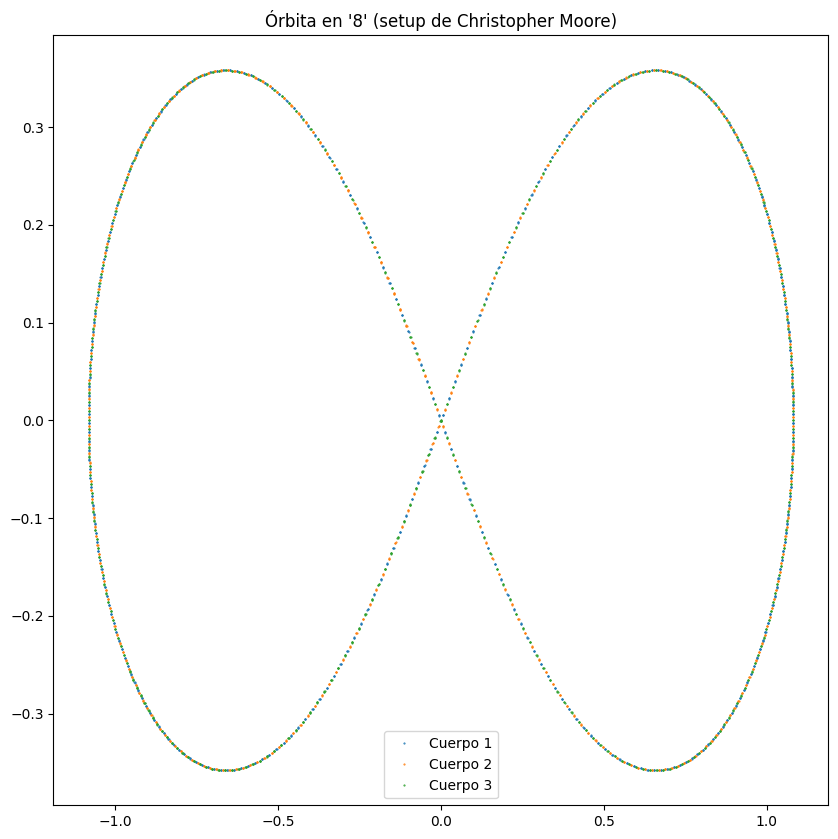

In [293]:
# ----------------------
# System parameters
# ----------------------

G = 1.0 # Gravitational constant normalized
m1 = m2 = m3 = 1.0

# ----------------------------
# Initial conditions
# ----------------------------

r1 = np.array([0.97000436, -0.24308753, 0.0])
r2 = np.array([-0.97000436, 0.24308753, 0.0])
r3 = np.array([0.0, 0.0, 0.0])

v1 = np.array([0.4662036850, 0.43236573, 0.0])
v2 = np.array([0.4662036850, 0.43236573, 0.0])
v3 = np.array([-0.93240737, -0.86473146, 0.0])

state0 = np.concatenate((r1, v1, r2, v2, r3, v3))
t_max = 20
num_points = 1000
t = np.linspace(0, t_max, num_points)

# ----------------------------
# Solve the system
# ----------------------------
sol = solve_three_body_problem(m1, m2, m3, state0, t)
plot_projection_three_body_solution(sol, "Órbita en '8' (setup de Christopher Moore)")


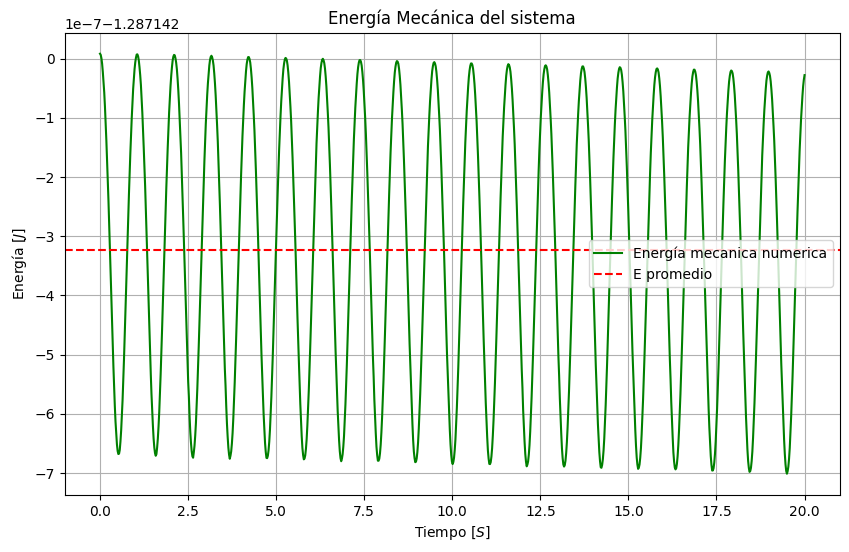

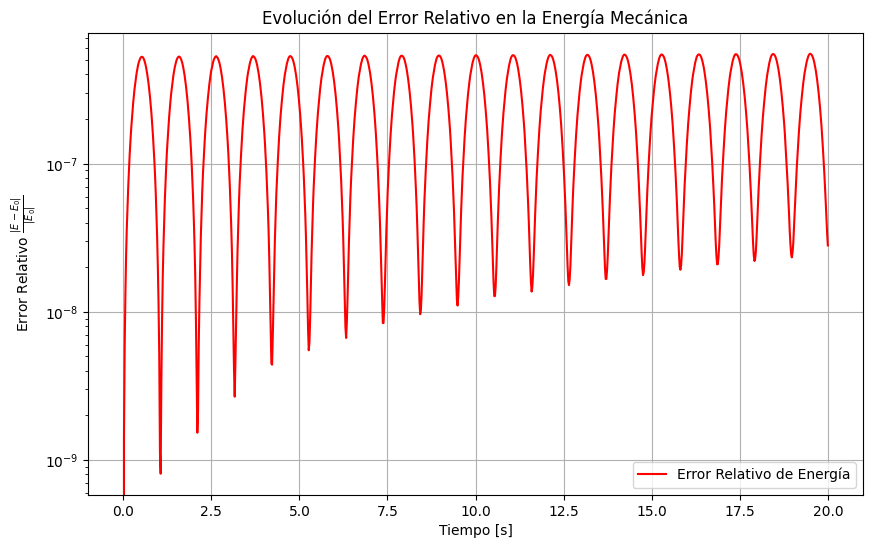

In [294]:
potential_energy = np.zeros(num_points)
kinetic_energy = np.zeros(num_points)

for i in range(num_points):
    r1 = np.array([sol.x1[i], sol.y1[i], sol.z1[i]])
    r2 = np.array([sol.x2[i], sol.y2[i], sol.z2[i]])
    r3 = np.array([sol.x3[i], sol.y3[i], sol.z3[i]])

    v1 = np.array([sol.vx1[i], sol.vy1[i], sol.vz1[i]])
    v2 = np.array([sol.vx2[i], sol.vy2[i], sol.vz2[i]])
    v3 = np.array([sol.vx3[i], sol.vy3[i], sol.vz3[i]])

    potential_energy[i] = -G * (
        m1 * m2 / np.linalg.norm(r2 - r1)
        + m1 * m3 / np.linalg.norm(r3 - r1)
        + m2 * m3 / np.linalg.norm(r3 - r2)
    )
    kinetic_energy[i] = 0.5 * (
        m1 * np.linalg.norm(v1) ** 2
        + m2 * np.linalg.norm(v2) ** 2
        + m3 * np.linalg.norm(v3) ** 2
    )

total_energy = potential_energy + kinetic_energy


plt.figure(figsize=(10, 6))
plt.plot(t, total_energy, color="green", label="Energía mecanica numerica")
plt.axhline(
    y=np.mean(potential_energy + kinetic_energy),
    color="r",
    linestyle="--",
    label="E promedio",
)
plt.legend()
plt.grid(True)
plt.ylabel("Energía $[J]$")
plt.xlabel("Tiempo $[S]$")
plt.title("Energía Mecánica del sistema")
plt.show()


relative_error =  np.abs(total_energy - total_energy[0]) / np.abs(total_energy[0])
plt.figure(figsize=(10, 6))
plt.plot(t, relative_error, label="Error Relativo de Energía", color='r')
plt.yscale("log")  
plt.xlabel("Tiempo [s]")
plt.ylabel("Error Relativo $\\frac{|E - E_0|}{|E_0|}$")
plt.title("Evolución del Error Relativo en la Energía Mecánica")
plt.legend()
plt.grid(True)
plt.show()


Succesful: True
Message: The solver successfully reached the end of the integration interval.


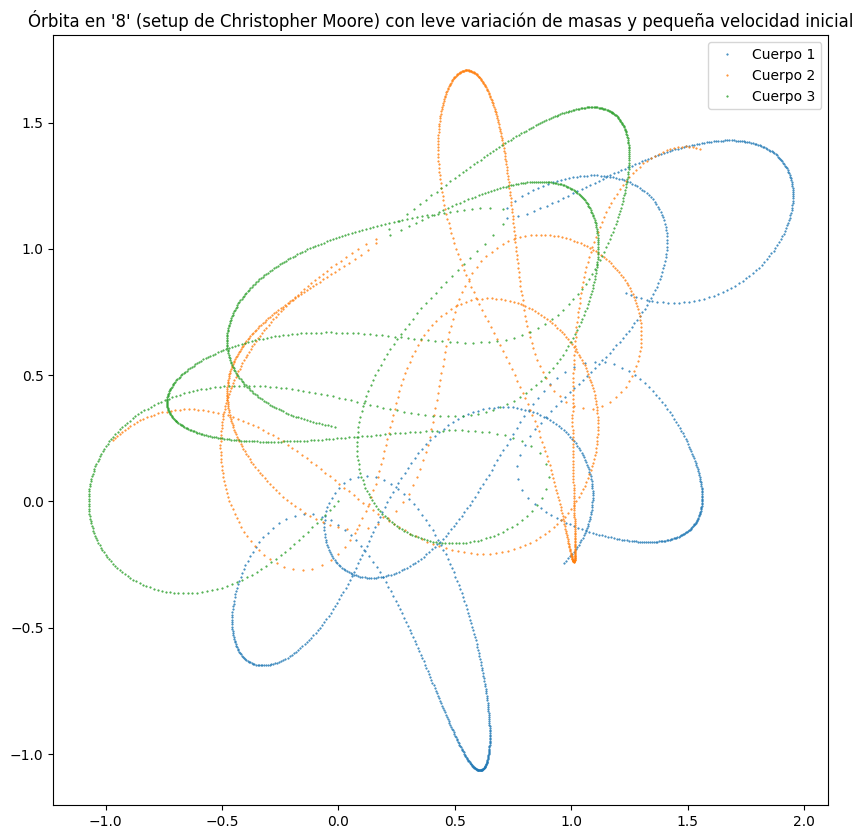

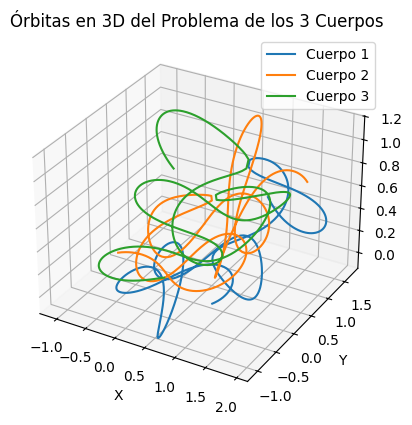

In [300]:
# ----------------------
# System parameters
# ----------------------

G = 1.0  # Gravitational constant normalized
m1 = 1.1
m2 = 1
m3 = 0.9

# ----------------------------
# Initial conditions
# ----------------------------

r1 = np.array([0.97000436, -0.24308753, 0.0])
r2 = np.array([-0.97000436, 0.24308753, 0.0])
r3 = np.array([0.0, 0.0, 0.0])

v1 = np.array([0.4662036850, 0.43236573, 0.1])
v2 = np.array([0.4662036850, 0.43236573, 0.0])
v3 = np.array([-0.93240737, -0.86473146, 0.0])

state0 = np.concatenate((r1, v1, r2, v2, r3, v3))

t_max = 20
num_points = 1000
t = np.linspace(0, t_max, num_points)

# ----------------------------
# Solve the system
# ----------------------------

sol = solve_three_body_problem(m1, m2, m3, state0, t)
plot_projection_three_body_solution(sol, "Órbita en '8' (setup de Christopher Moore) con leve variación de masas y pequeña velocidad inicial")
plot_three_body_solution(sol)
